In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.metrics")


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, fbeta_score, make_scorer
from sklearn.metrics import precision_recall_curve, auc
from scipy.sparse import hstack, csr_matrix,vstack


### Modelling

#### Reading the data frame from csv file

In [6]:
train = pd.read_csv(r"C:\Users\win\Desktop\Data_Science\4th_sem\Applied_ML\spam_detection\train.csv")
val = pd.read_csv(r"C:\Users\win\Desktop\Data_Science\4th_sem\Applied_ML\spam_detection\validation.csv")
test = pd.read_csv(r"C:\Users\win\Desktop\Data_Science\4th_sem\Applied_ML\spam_detection\test.csv")

# seperating the Features and target variable
X_train, y_train = train.drop("spam", axis = 1), train["spam"]
X_val, y_val = val.drop("spam", axis = 1), val["spam"]
X_test, y_test = test.drop("spam", axis = 1), test["spam"]

#### Vectorization using TF-IDF

In [7]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train["text"])

def df_after_vectorization(X,no_of_words,vectorizer):
    X = vectorizer.transform(X['text'])
    no_of_words_column = csr_matrix(no_of_words['no_of_words'].values.reshape(-1, 1))
    # Horizontally stack the sparse matrices
    X_combined = hstack([X, no_of_words_column])
    return X_combined

    

In [8]:
import joblib
joblib.dump(vectorizer, 'tfidfvectorizer.pkl')

['tfidfvectorizer.pkl']

In [9]:
X_val = df_after_vectorization(X_val,val,vectorizer)
X_test = df_after_vectorization(X_test,test,vectorizer)
no_of_words_column = csr_matrix(train['no_of_words'].values.reshape(-1,1))
X_train = hstack([X_train,no_of_words_column])


#### Functions for viewing confusion matrix and evaluating the model

In [10]:
def display_confusion_matrix(y_actual, y_pred):
    target_labels = ["Not Spam", "Spam"]
    cm = confusion_matrix(y_actual, y_pred)
    display_cm = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = target_labels)
    fig, ax = plt.subplots(figsize = (5, 3))
    display_cm.plot(ax = ax, cmap = "Blues")

def evaluate(y_actual, y_pred,beta):
    metric = fbeta_score(y_actual, y_pred, beta=beta)
    print("Classification Report:\n {}".format(classification_report(y_actual, y_pred)))
    print("f beta score: {}".format(metric))
    display_confusion_matrix(y_actual, y_pred)
    return metric
    

#### F beta score is taken as performance metric.
#### We should minimize false positives (predicting spam which are not spam). hence importance is given to precision.
#### Hence beta is taken as 0.8 (< 1)


In [11]:
beta = 0.8
scorer = make_scorer(fbeta_score, beta=beta)

In [12]:
X_train_val = vstack([X_train,X_val])
y_train_val = pd.concat([y_train,y_val])

#### 2) Logistic Regression

In [13]:

# Define the Logistic Regression model
lr_model = LogisticRegression(random_state=42)

# Define the hyperparameters to search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

# Create the GridSearchCV object with 5-fold cross-validation
grid_search = GridSearchCV(estimator=lr_model, param_grid=param_grid, cv=5, scoring=scorer)

# Fit the model to the training data with cross-validation
grid_search.fit(X_train_val, y_train_val)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)


Best Hyperparameters: {'C': 100, 'penalty': 'l2'}


Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       872
           1       0.99      0.99      0.99       274

    accuracy                           0.99      1146
   macro avg       0.99      0.99      0.99      1146
weighted avg       0.99      0.99      0.99      1146

f beta score: 0.9868549604760637


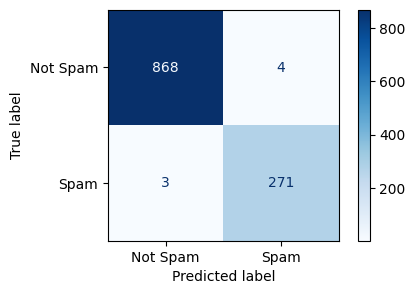

In [14]:
# Retrieve the best model
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred_lr_tuned = best_model.predict(X_test)

# Evaluate the model on the test set
fbeta_Score_lr_tuned = evaluate(y_test, y_pred_lr_tuned,beta)

In [15]:
import joblib
# Save the model to a file
joblib.dump(best_model, 'logistic_reg.pkl')


['logistic_reg.pkl']